## Test Case: Applications to real world EHR data

We have a dataset that includes demographic information,
diagnoses, and Emergency Department (ED) visits for a cohort of
patients over the period 2010-2012. This is a small, relatively simple dataset with only 400 unique patients.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline
import networkx as nx
import sys
import os
import json

# import locally stored library
sys.path.append('C:\\Users\\dreww\\Desktop')
sys.path.append('C:\\Users\\dreww\\Desktop\\vu_informatics')
from icd9 import icd9

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

,empi,dia_date,dia_code,dia_name,provider,dia_flag,inpatient_outpatient
0,412857024,2012-04-01,291.2,Alcohol-induced persisting dementia,"Hosseini, Ahmad, M.D.",admitting,inpatient
1,733570627,2011-12-07,260,Kwashiorkor,"Hansen, Michael, M.D.",primary,outpatient
2,838754425,2013-06-23,416,Chronic pulmonary heart disease,"Hansen, Michael, M.D.",admitting,inpatient
3,546413564,2010-12-11,729.1,"Mylagia and myositis, unspecified","Dirichlet, Amir, M.D.",admitting,inpatient
4,452148563,2008-07-29,272.4,Other and unspecified hyperlipidemia,"Armstrong, Sebastian, M.D.",NaN,outpatient


(5893, 7)

Number of unique patients:  400
Avg number of diagnoses per person:  14.7325


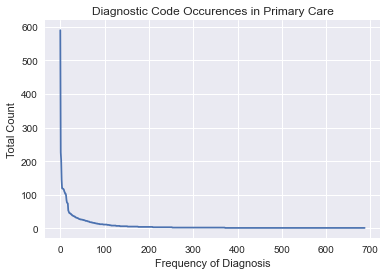

In [2]:
# this dataset contains information on the date and nature of primary diagnoses
diag = pd.read_csv('data/Harvard_EHR_Dataset/dia.csv')
diag.head()
diag.shape
print('Number of unique patients: ', diag.empi.nunique())
print('Avg number of diagnoses per person: ', diag.groupby('empi').count()['dia_code'].mean())
y = diag.dia_code.value_counts().sort_values(ascending=False).values
x = np.arange(0, len(diag.dia_code.unique()))
_ = plt.plot(x, y)
_ = plt.ylabel('Total Count')
_ = plt.xlabel('Frequency of Diagnosis')
_ = plt.title('Diagnostic Code Occurences in Primary Care')

In [3]:
# this dataset contains demographic information and indication of mortality
dem = pd.read_csv('data/Harvard_EHR_Dataset/dem.csv')
dem.head()
dem.shape
print('Deceased %: ', 1 - dem.date_of_death.isna().sum() / len(dem))
dem.gender.value_counts()
dem.age.describe()
dem.vital_status.value_counts()

,empi,name,gender,date_of_birth,age,race,vital_status,date_of_death
0,742415486,Ms.Baudoin,female,1937-08-07,77,Black-BLACK,NaN,NaN
1,746287608,Ms.Koo,female,1983-04-21,31,White-WHITE,NaN,NaN
2,415900342,Ms.Shurtleff,female,1918-03-11,96,White-WHITE,NaN,NaN
3,967071533,Ms.Mukai,female,1947-04-01,67,Black-BLACK,NaN,NaN
4,679830259,Ms.Haapala,female,1967-02-03,47,Black-BLACK,NaN,NaN


(400, 8)

Deceased %:  0.3375


female    200
male      200
Name: gender, dtype: int64

count    400.00000
mean      69.43500
std       21.77835
min       22.00000
25%       50.00000
50%       73.00000
75%       91.00000
max       97.00000
Name: age, dtype: float64

deceased    135
Name: vital_status, dtype: int64

In [4]:
# this dataset describes emergency department visits, icd9 codes with descriptions, and clinical notes 
ed_notes = pd.read_csv('data/Harvard_EHR_Dataset/ed_visits.txt', delimiter='$')
ed_notes.head()
print('Average number of ER visits ', np.mean(ed_notes.groupby(['empi'])['visit_date'].count()))
ed_notes.length_of_stay.describe()

,empi,visit_date,admit_date,discharge_date,length_of_stay,principal_dia_code,principal_dia_name,additional_dia_code,note_text
0,940785937,2013-05-14,2013-05-14 23:59:19,2013-05-15 00:52:57,54,724.2,Lumbago,"719.46,786.2,786.2,V62.85",[report_beginning]\n\n940785937|2013-05-14|fin...
1,412857024,2012-01-20,2012-01-20 22:53:54,2012-01-21 02:51:49,238,781.0,Abnormal involuntary movements,NaN,[report_beginning]\n\n412857024|2012-01-20|fin...
2,285331782,2011-12-09,2011-12-09 12:54:56,2011-12-09 17:37:59,283,786.59,Other chest pain,"996.73,719.46,724.2,959.09",[report_beginning]\n\n285331782|2011-12-09|fin...
3,916658044,2011-05-23,2011-05-23 14:12:04,2011-05-23 21:21:44,430,780.4,Dizziness and giddiness,"719.46,820.8,789.01,780.50",[report_beginning]\n\n916658044|2011-05-23|fin...
4,172824291,2012-09-30,2012-09-30 03:44:42,2012-09-30 07:32:36,228,789.02,"Abdominal pain, left upper quadrant","540.9,998.30,784.2,578.9",[report_beginning]\n\n172824291|2012-09-30|uns...


Average number of ER visits  2.4884393063583814


count    869.000000
mean     232.133487
std      118.202272
min     -127.000000
25%      145.000000
50%      232.000000
75%      310.000000
max      650.000000
Name: length_of_stay, dtype: float64

principal_dia_code     308
additional_dia_code    831
dtype: int64

1140

1135

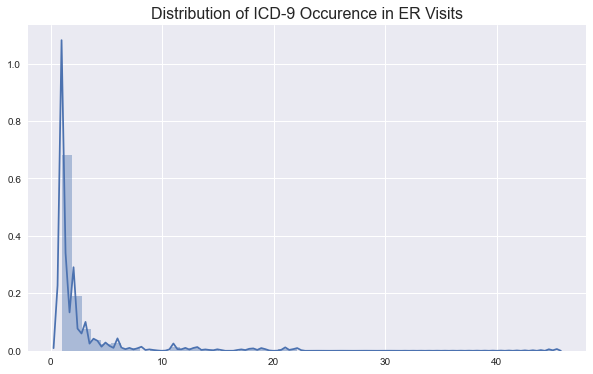

In [5]:
diagnoses = ed_notes.principal_dia_code.value_counts().reset_index()
diagnoses.columns = ['icd_code', 'occurences']
ed_notes[['principal_dia_code', 'additional_dia_code']].nunique()
len(np.unique(list(ed_notes.principal_dia_code.values) + list(ed_notes.additional_dia_code.values)))
len(np.unique(ed_notes.dropna()[['principal_dia_code', 'additional_dia_code']].values))
_ = plt.figure(figsize=(10,6))
_ = plt.title('Distribution of ICD-9 Occurence in ER Visits', size=16)
_ = sns.distplot(diagnoses.occurences.values)

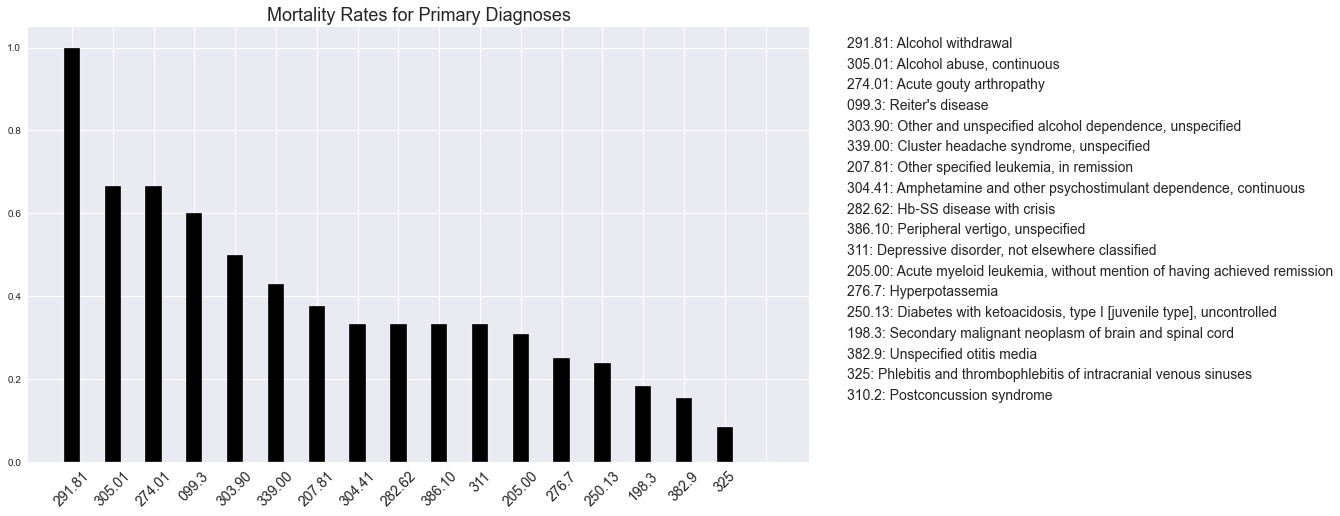

In [6]:
icd_mortality = ed_notes[['empi', 'principal_dia_code', 'principal_dia_name']].merge(dem[['empi', 'vital_status']], on='empi')
icd_mortality['vital_status'] = icd_mortality.vital_status.apply(lambda x: 1 if x == 'deceased' else np.nan_to_num(x, 0))
icd_codes = icd_mortality.groupby(['principal_dia_code']).count().reset_index().principal_dia_code.values
code_counts = icd_mortality.groupby(['principal_dia_code'])['empi'].count().values
code_mortalities = icd_mortality.groupby(['principal_dia_code'])['vital_status'].sum().values
mortality_scores = code_mortalities[code_counts > 2] / code_counts[code_counts > 2]
x_pos = np.arange(0, len(mortality_scores)/4)
icd_dict = dict(zip(diag.dia_code.values, diag.dia_name.values))
code_labels = icd_codes[np.argsort(mortality_scores)[::-1]][::4]
icd_labels = [x + ': ' + icd_dict[x] for x in code_labels]

plt.figure(figsize=(14,8))
plt.bar(x_pos, np.sort(mortality_scores)[::-1][::4], width=0.4, color='black', edgecolor='white')
plt.xticks(x_pos, rotation=45)
ax = plt.gca()
ax.set_xticklabels(code_labels[:-1], size=14)
for i,label in enumerate(icd_labels):
    plt.text(19, 1-i*0.05, label, size=14)
plt.title('Mortality Rates for Primary Diagnoses', size=18)
plt.show();

### Define ICD Relations by Co-occurences in Dataset

Algebraic Connectivity:  1.8414295033240842
Average Clustering:  0.6697203109344996


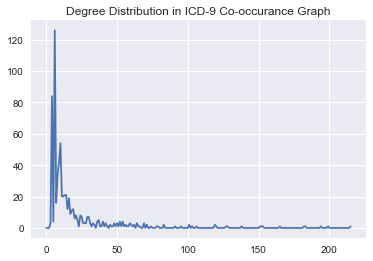

In [7]:
# define edge pairs from secondary codes to primary icd code
edges = []
for i in range(len(ed_notes)):
    if ed_notes.iloc[i].isna().sum() > 0:
        continue
    primary_code = ed_notes.principal_dia_code[i]
    if ',' in ed_notes.additional_dia_code[i]:
        secondary_codes = ed_notes.additional_dia_code[i].split(",")
        for i, code in enumerate(secondary_codes):
            edges.append([code, primary_code])
            for j in range(i, len(secondary_codes)):
                edges.append([code, secondary_codes[j]])
    else:
        edges.append([ed_notes.additional_dia_code[i], primary_code])
G = nx.Graph(edges)
print('Algebraic Connectivity: ', nx.algebraic_connectivity(G))
print('Average Clustering: ', nx.average_clustering(G))
plt.plot(nx.degree_histogram(G))
plt.title('Degree Distribution in ICD-9 Co-occurance Graph');

In [8]:
# get total number of icd code occurrences
counts = {}
for e in edges:
    if e[0] not in counts.keys():
        counts[e[0]] = 1
    else:
        counts[e[0]] += 1
    if e[1] not in counts.keys():
        counts[e[1]] = 1
    else:
        counts[e[1]] += 1
    
# examine top 10 most frequent codes
top_ix = np.array(list(counts.keys()))[np.argsort(list(counts.values()))][::-1]
freq_codes = [icd_dict[x] for x in top_ix[:10]]
dict(zip(freq_codes, [counts[x] for x in top_ix[:10]]))

#len(list(counts.keys()))
#len(list(icd_dict.items()))
#len((set(icd_dict).difference(set([icd9.short_to_decimal(x) for x in counts.keys()]))))

{'Chest pain, unspecified': 688,
 'Abdominal pain, unspecified site': 630,
 'Abdominal pain, other specified site': 612,
 'Headache': 546,
 'Pain in limb': 546,
 'Shortness of breath': 426,
 'Lumbago': 424,
 'Other chest pain': 422,
 'Syncope and collapse': 384,
 'Fever, unspecified': 346}

In [9]:
# get unique icd codes
node_list = []
add_codes = np.array(ed_notes['additional_dia_code'].dropna().apply(lambda x: x.split(',') if ',' in x else x))
for l in add_codes:
    node_list += l
nodes = list(set(node_list).union(list(np.ravel(np.array(ed_notes['principal_dia_code'].values)))))
nodes = [icd9.decimal_to_short(node) for node in nodes]
edges = [[icd9.decimal_to_short(e[0]), icd9.decimal_to_short(e[1])] for e in edges]
observed_chapters = np.sort([node for node in nodes if len(node) == 3])

# optionally add edges from each chapter to highest level, center node            
for chapter in observed_chapters:
    edges.append([chapter, 'ICD-9_Diagnoses'])
nodes.append('ICD-9_Diagnoses')

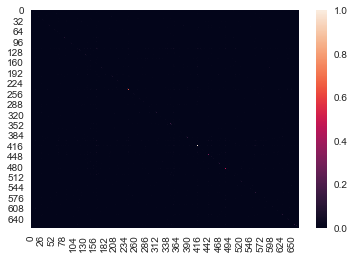

In [10]:
# define a co-occurence matrix where M[i,j] gives total co-occurences between nodes i,j 
M = np.zeros((len(nodes), len(nodes)))
node_to_index = dict(zip(nodes, np.arange(len(nodes))))
for e in edges:
    M[node_to_index[e[0]], node_to_index[e[1]]] += 1
M.shape
sns.heatmap((M/M.max()));

In [12]:
# define edge relations as a dataframe            
icd_df = pd.DataFrame(edges, columns=['u', 'v']).drop_duplicates()
icd_df.head()
icd_df.info()
icd_df.to_csv('data/icd_data/icd_observed_relations.csv', index=None)

,u,v
0,71946,7242
1,71946,71946
2,71946,7862
4,71946,V6285
5,7862,7242


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7260 entries, 0 to 11957
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   u       7260 non-null   object
 1   v       7260 non-null   object
dtypes: object(2)
memory usage: 170.2+ KB


In [13]:
# define mappings between chapter name & range to integer class labels
observed_chapter_name_label = {}
for i, k in enumerate(observed_chapters):
    observed_chapter_name_label[k] = i

# assign each node to its chapter class label
node_labels = {}
for i in range(icd_df.shape[0]):
    u = icd_df.iloc[i, 0]
    v = icd_df.iloc[i, 1]
    if v in observed_chapters:
        node_labels[u] = observed_chapter_name_label[v]

### Train poincare model on observed ICD relations

In [14]:
# import modules within repository
sys.path.append('/Users/drew/Desktop/hyperbolic-learning/utils')
sys.path.append('/Users/drew/Desktop/hyperbolic-learning/utils/poincaré_embeddings')
from embed import *

In [177]:
# train poincare embeddings and save output embedding coordinates
fin = 'data/icd_data/icd_observed_relations.csv' # input path with stored relations
fout = 'data/icd_data/icd_observed_embeddings_tmp.csv' # output path to write embedding coordinates

# call function to train gensim's poincare embedding model
train_embeddings(input_path=fin, delimiter=',', output_path=fout, epochs=20, burn_in_alpha=0.01, 
                 batch_size=20, burn_in=10, alpha=0.1, negative=20)

INFO:gensim.models.poincare:loading relations from train data..
INFO:gensim.models.poincare:loaded 7261 relations from train data, 668 nodes
INFO:gensim.models.poincare:training model of size 2 with 1 workers on 7261 relations for 20 epochs and 10 burn-in epochs, using lr=0.10000 burn-in lr=0.01000 negative=20
INFO:gensim.models.poincare:starting burn-in (10 epochs)----------------------------------------
INFO:gensim.models.poincare:burn-in finished
INFO:gensim.models.poincare:starting training (20 epochs)----------------------------------------
INFO:gensim.models.poincare:training finished
INFO:gensim.models.utils_any2vec:storing 668x2 projection weights into data/icd_data/icd_observed_embeddings_tmp.csv


In [15]:
# load embedding coordinates and prepare data for plotting in the poincare disk
emb = load_embeddings('data/icd_data/icd_observed_embeddings_tmp.csv', delim=' ')
emb.head()
emb_data = np.array(emb.iloc[:, 1:3])
emb_dict = dict(zip(emb.node.values, emb_data))
edge_list = [list(arr) for arr in np.array(icd_df)]

#labels = emb.node.apply(lambda x: node_labels[x] if x in node_labels.keys() else 1)
labels = np.repeat(0, len(emb)-1)
#chapter_label_range = {v:k for k,v in chapter_range_label.items()}

,node,x,y
0,78650,0.080655,-0.079254
1,78900,0.246292,0.204163
2,78909,-0.300722,-0.072834
3,7840,0.154729,-0.164653
4,7295,-0.132292,-0.123495


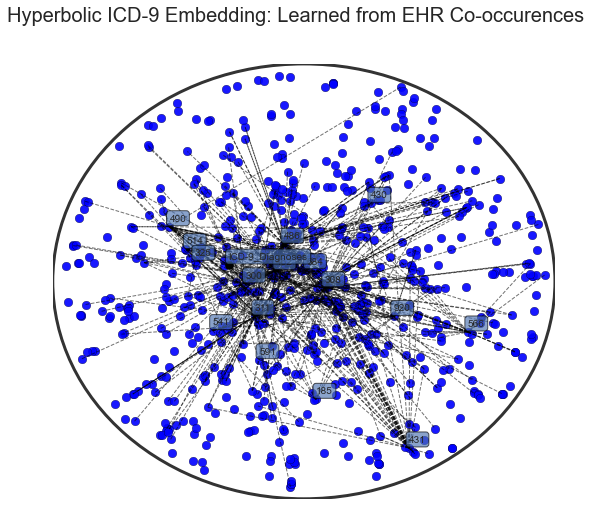

In [16]:
# import cross library module
sys.path.append('/Users/drew/Desktop/vu-informatics/utils')
from poincare_viz_icd import *

# add labels for chapters and select only high level edges
chapter_emb = emb[emb.node.apply(lambda x: x in observed_chapters)]
chapter_emb_dict = dict(zip(chapter_emb.node.values, chapter_emb.iloc[:, 1:3].values))
chapter_edges = [e for e in edge_list if e[0] in observed_chapters or e[1] in observed_chapters]

plot_poincare_icd(emb, labels, edge_list=chapter_edges, add_labels=True,
                  label_dict=chapter_emb_dict, edge_frac=1, plot_frac=1, label_frac=0,
                  save=True, title='Learned from EHR Co-occurences');

correlation:  0.32276842606103595


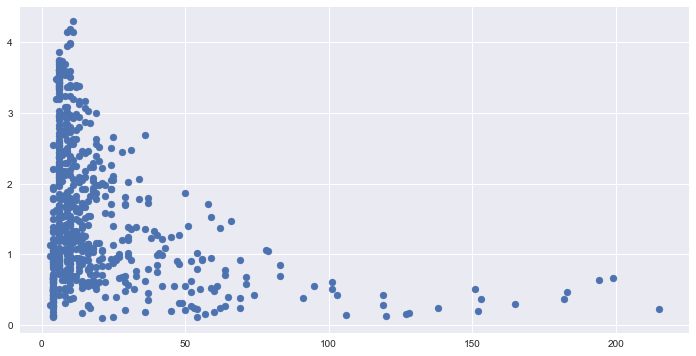

In [17]:
# plot distance from center vs. node degree
radial_dist = []
degree_counts = []
for node in G.nodes():
    radial_dist.append(poincare_dist([0, 0], emb[emb['node'] == icd9.decimal_to_short(node)].iloc[:,1:3]))
    degree_counts.append(G.degree(node))
plt.figure(figsize=(12,6))
print('correlation: ', np.abs(np.corrcoef(degree_counts, radial_dist)[0,1]))
plt.scatter(degree_counts, radial_dist);

### Load pre-trained ICD-9 Embeddings 

In [18]:
chapters = icd9.icd9Chapters
drop_supplementary = True
s1 = 'Supplementary Classification Of External Causes Of Injury And Poisoning'
s2 = 'Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services'
if drop_supplementary:
    for s in [s1, s2]:
        if s in chapters.keys():
            drop = chapters.pop(s)
    
# define mappings between chapter name & range to integer class labels
chapter_name_range = {}
for k,v in chapters.items():
    chapter_name_range[k] = v[0] + '_' + v[1]
chapter_range_name = {v:k for k,v in chapter_name_range.items()}

chapter_name_label = {}
for i, k in enumerate(chapters.keys()):
    chapter_name_label[k] = i
chapter_range_label = {k:i for i, k in enumerate(chapter_range_name)}
    
# load embedding coordinates and prepare data for plotting in the poincare disk
emb = pd.read_csv('data/icd_data/icd_final_embeddings.csv')
emb.head()

FileNotFoundError: [Errno 2] File data/icd_data/icd_final_embeddings.csv does not exist: 'data/icd_data/icd_final_embeddings.csv'

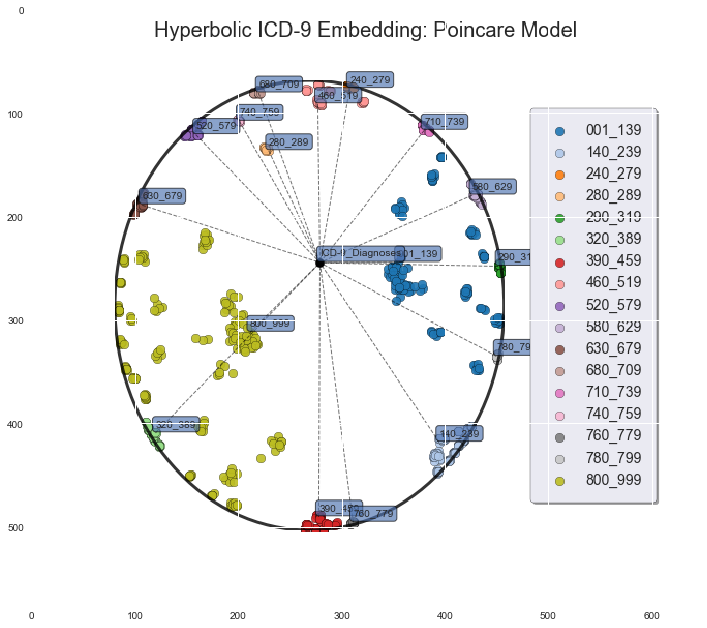

In [41]:
import matplotlib.image as mpimg
# visualize poincare icd-9 embedding
plt.figure(figsize=(12,12))
img=mpimg.imread('images/Poincare_Model_ICD9.png')
plt.imshow(img);

### Use ICD-9 Embeddings in Mortality Prediction Task

In [19]:
patient_diags = {}
for empi in dem.empi.values:
    patient_diags[empi] = diag[diag.empi == empi].dia_code.values
list(patient_diags.items())[:5]

[(742415486,
  array(['308.3', '440.0', '300.01', '272.4', '263', '2761', '300.00',
         '719.40', '402.10', '174.9', '272.4', '300.10', '789.06', '425.9',
         '250.50', '202.80', '141', '702.19', '300.10'], dtype=object)),
 (746287608,
  array(['300.01', '272.4', '2768', '401.1', '533.90', '426.13', '202.80',
         '173.3', '159', '070.54', '309.1', '308.9', '174.9', '300.09',
         '789.00'], dtype=object)),
 (415900342,
  array(['272.4', '2764', '4404', '202.80', '198.3', '308.3', '070.51',
         '433.11', '308', '2869', '465.9', '300.01', '263', '654.43',
         '272.4', '560.32', '342'], dtype=object)),
 (967071533,
  array(['308.9', '188.5', '300', '200.78', '425.9', '308.9', '309.1',
         '272.4', '789.00', '308.3'], dtype=object)),
 (679830259,
  array(['789.00', '272.4', '787.01', '174.9', '426.11', '296.34', '300.09',
         '174.9', '174.9', '274.01', '196.3', '702.19', '263'], dtype=object))]

In [20]:
dem['vital_status'] = dem['vital_status'].fillna(0).replace('deceased', 1)
ehr_data = dem[['empi', 'gender', 'age', 'vital_status']].merge(diag.groupby(['empi'])['dia_code'].count().reset_index(), on=['empi'])
ehr_data.rename(columns={"vital_status":"deceased", "dia_code": "num_diags"}, inplace=True)
ehr_data.head()
ehr_data.shape

,empi,gender,age,deceased,num_diags
0,742415486,female,77,0,19
1,746287608,female,31,0,15
2,415900342,female,96,0,17
3,967071533,female,67,0,10
4,679830259,female,47,0,13


(400, 5)

In [21]:
num_visits = ed_notes.groupby(['empi'])['visit_date'].count().reset_index()
num_visits.columns = ['empi', 'er_visits']
avg_los = ed_notes.groupby(['empi'])['length_of_stay'].mean().reset_index()
avg_los.columns = ['empi', 'avg_length_of_stay']
num_visits.merge(avg_los, on=['empi']).head()
num_visits.shape

,empi,er_visits,avg_length_of_stay
0,101962493,2,234.500000
1,115649349,1,333.000000
2,116008610,3,280.333333
3,117990558,1,142.000000
4,117997941,4,262.500000


(346, 2)

In [22]:
X = ehr_data.merge(num_visits, on='empi', how='left')
X['male'] = X.gender.apply(lambda x: 1 if x == 'male' else 0)
X.drop(['gender'], axis=1, inplace=True)

decimal_nodes = [icd9.short_to_decimal(x) for x in emb.node.values]
embed_x = []
embed_y = []
for key,vals in patient_diags.items():
    embed_1 = [emb[emb.node == icd9.decimal_to_short(dec_code)]['x'].values for dec_code in vals]
    embed_2 = [emb[emb.node == icd9.decimal_to_short(dec_code)]['y'].values for dec_code in vals]
    embed_x.append(embed_1)
    embed_y.append(embed_2)

mean_embed_x = []
for l in np.array(embed_x):
    mean_embed_x.append(np.array(l)[[len(x) > 0 for x in l]].mean()[0])    

mean_embed_y = []
for l in np.array(embed_y):
    mean_embed_y.append(np.array(l)[[len(x) > 0 for x in l]].mean()[0])
    
X['embed_1'] = mean_embed_x
X['embed_2'] = mean_embed_y

X.isna().sum()
X['er_visits'] = X['er_visits'].fillna(0)

empi          0
age           0
deceased      0
num_diags     0
er_visits    54
male          0
embed_1       0
embed_2       0
dtype: int64

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score

X_train, X_test, y_train, y_test = train_test_split(X.drop(['empi','deceased'], axis=1), X['deceased'].values)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_pred, y_test))
roc_auc_score(y_pred, y_test)
y_pred
model.coef_

LogisticRegression()

              precision    recall  f1-score   support

           0       0.88      0.78      0.83        68
           1       0.62      0.78      0.69        32

    accuracy                           0.78       100
   macro avg       0.75      0.78      0.76       100
weighted avg       0.80      0.78      0.79       100



0.7803308823529412

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0])

array([[ 0.08114018, -0.06549745, -0.12935062, -0.13713253,  0.88930821,
        -0.36656275]])

In [91]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score, precision_score
scoring = ['precision_macro', 'recall_macro']
clf = LogisticRegression(random_state=1)
scores1 = cross_validate(clf, X=X.drop(['empi','deceased'], axis=1), y=X['deceased'].values, cv=10, scoring=scoring)
scores2 = cross_validate(clf, X=X.drop(['empi','deceased', 'embed_1', 'embed_2'], axis=1), y=X['deceased'].values, cv=5, scoring=scoring)
np.mean(scores1['test_recall_macro'])
np.mean(scores1['test_precision_macro'])
np.mean(scores2['test_recall_macro'])
np.mean(scores2['test_precision_macro'])

0.8013431013431014

0.8204777198317194

0.7933612858141159

0.8036955559653329